In [1]:
library(SparkR);
library(zoo);
library(xts);


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:SparkR’:

    first, last



In [2]:
spark <- sparkR.session(master = "spark://192.168.0.11:7077", 
               sparkConfig = list(spark.executor.cores = "4",
                                 spark.speculation = "true",
                                 spark.driver.memory = "20g",
                                 spark.executor.memory = "8g",
                                 spark.driver.maxResultSize = "10g"))


Spark package found in SPARK_HOME: /home/spark/spark


Launching java with spark-submit command /home/spark/spark/bin/spark-submit   --driver-memory "20g" sparkr-shell /tmp/RtmpEbs1cy/backend_port45e6394b874d 


In [3]:
data <-  (read.df("/tmp/f/train_test.csv",  "csv", header="true",inferSchema = "true"))

In [4]:
data <- cache(filter(data, data$istrain>0))

In [5]:
dim(data)

[1] 125497040        16

In [6]:
head(data)

index date       istrain item_nbr onpromotion store_nbr unit_sales dcoilwtico
1 0     2013-01-01 1       103665   -1          25        2.0794415  NA        
2 1     2013-01-01 1       105574   -1          25        0.6931472  NA        
3 2     2013-01-01 1       105575   -1          25        1.0986123  NA        
4 3     2013-01-01 1       108079   -1          25        0.6931472  NA        
5 4     2013-01-01 1       108701   -1          25        0.6931472  NA        
6 5     2013-01-01 1       108786   -1          25        1.3862944  NA        
  city state type cluster holiday family class perishable
1 20   13    3    1       1        5     2712  1         
2 20   13    3    1       1       12     1045  0         
3 20   13    3    1       1       12     1045  0         
4 20   13    3    1       1       12     1030  0         
5 20   13    3    1       1        9     2644  1         
6 20   13    3    1       1        7     3044  0

In [7]:
printSchema(data)

root
 |-- index: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- istrain: integer (nullable = true)
 |-- item_nbr: integer (nullable = true)
 |-- onpromotion: integer (nullable = true)
 |-- store_nbr: integer (nullable = true)
 |-- unit_sales: double (nullable = true)
 |-- dcoilwtico: double (nullable = true)
 |-- city: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- type: integer (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- family: integer (nullable = true)
 |-- class: integer (nullable = true)
 |-- perishable: integer (nullable = true)


In [8]:
salesData <- cache(select(data, c("date",'item_nbr','store_nbr','dcoilwtico','unit_sales')))

In [9]:
head(salesData)

date       item_nbr store_nbr dcoilwtico unit_sales
1 2013-01-01 103665   25        NA         2.0794415 
2 2013-01-01 105574   25        NA         0.6931472 
3 2013-01-01 105575   25        NA         1.0986123 
4 2013-01-01 108079   25        NA         0.6931472 
5 2013-01-01 108701   25        NA         0.6931472 
6 2013-01-01 108786   25        NA         1.3862944

In [40]:
a <- collect(filter(salesData, salesData$item_nbr==105575 & salesData$store_nbr==25))

In [41]:
item_ccf_daily <- function(df){
    library(xts)
    s <- read.zoo(df[c('date','unit_sales','dcoilwtico')])
    result <- ccf(s$unit_sales, diff(s$dcoilwtico),na.action = na.pass,plot=TRUE)
    racf <- result$acf[1:15]
    item <- df[1,'item_nbr']
    store <- df[1,'store_nbr']
    a <- c(store,item,dim(df)[1])
    y <- data.frame(rbind(c(a,racf)))
    colnames(y) <- c("store", "item", "N", 0:14)
    y
}

In [64]:
item_ccf_daily <- function(df){
    library(xts)
    s <- read.zoo(df[c('date','unit_sales','dcoilwtico')])
    result <- ccf(s$unit_sales, diff(s$dcoilwtico,10),na.action = na.pass,plot=TRUE)
result
}

In [65]:
c("store", "item", "N", 0:8)

[1] "store" "item"  "N"     "0"     "1"     "2"     "3"     "4"     "5"    
[10] "6"     "7"     "8"


Autocorrelations of series ‘X’, by lag

-2505600 -2419200 -2332800 -2246400 -2160000 -2073600 -1987200 -1900800 
   0.031    0.062    0.081    0.024    0.088    0.072    0.028    0.048 
-1814400 -1728000 -1641600 -1555200 -1468800 -1382400 -1296000 -1209600 
   0.071    0.028   -0.045    0.008    0.004   -0.051   -0.019   -0.035 
-1123200 -1036800  -950400  -864000  -777600  -691200  -604800  -518400 
  -0.045   -0.031   -0.017   -0.053   -0.023   -0.065   -0.046    0.006 
 -432000  -345600  -259200  -172800   -86400        0    86400   172800 
   0.010   -0.021    0.025    0.058    0.040    0.023    0.074    0.071 
  259200   345600   432000   518400   604800   691200   777600   864000 
   0.058    0.062    0.063    0.074    0.067    0.033   -0.029    0.015 
  950400  1036800  1123200  1209600  1296000  1382400  1468800  1555200 
   0.044   -0.048   -0.015   -0.004   -0.061   -0.118   -0.027   -0.034 
 1641600  1728000  1814400  1900800  1987200  2073600  2160000  2246400 
  -0.057  

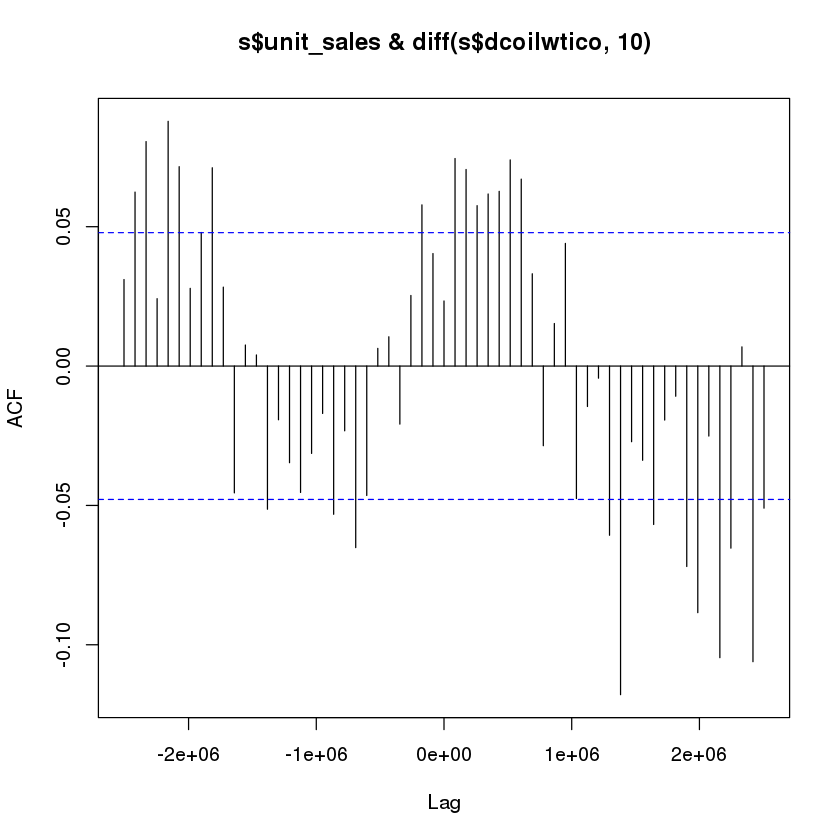

In [66]:
item_ccf_daily(a)

In [60]:
counts <- summarize(groupBy(salesData, salesData$store_nbr, salesData$item_nbr), count = n(salesData$unit_sales))

In [61]:
count(counts)

[1] 174685

In [148]:
result <- gapplyCollect(
    salesData,
    c("store_nbr", "item_nbr"),
    function(key, x) {
        y <- item_acf_daily(x)
        y
    })

In [149]:
dim(result)

[1] 174685     18

In [150]:
head(result)

store item    N    0 1           2           3           4          
1 1      364834 1109 1  0.19394594  0.14418049  0.12224387  0.12614727
2 1      456875  972 1  0.13193923  0.09852203  0.12985589  0.08307329
3 1      522941  818 1  0.02770142  0.03826764  0.03827924  0.01923153
4 1      839363 1520 1  0.26925274  0.26722175  0.24436603  0.25229819
5 1      979199  686 1 -0.06066153 -0.11109528  0.12801849 -0.11684836
6 1     1009512  267 1  0.20955790 -0.11040216 -0.15445031  0.27475022
  5           6           7           8          9            10         
1  0.06690929  0.11434005  0.12882583 0.11465606  0.075073505  0.09114222
2  0.03239337  0.07132749  0.11457999 0.01060488  0.074116756  0.01565967
3 -0.02136860  0.02490475  0.06648673 0.05557495 -0.008288747  0.10039420
4  0.25617814  0.22543933  0.30124109 0.19810034  0.197624381  0.16533421
5 -0.01384686  0.03695651 -0.03422987 0.04948583  0.037137203 -0.04407600
6 -0.08962202 -0.16184254  0.04611225 0.22671599  0.001819199  0.01316343
  11           12          13           14         
1  0.040313236  0.06815303  0.010498793 0.133428471
2  0.065762460  0.11608402  0.145098829 0.109544007
3 -0.042472779 -0.01358318  0.007286757 0.068605517
4  0.168548101  0.15483604  0.147183211 0.278882218
5  0.003794936 -0.08960952  0.013831287 0.002391063
6 -0.115055944  0.10914140 -0.137011192 0.048030004

In [151]:
write.csv(file="../input/sales_acf.csv",x=result)